In [7]:
import os
import pandas as pd
import numpy as np
from geopy.geocoders import Nominatim
from geopy.distance import geodesic
from datetime import datetime

# --- Configuration: Specify the user ID to search for ---
user_id = "UID25840"  # Change this to your desired user ID

# --- Helper function to extract city from an address ---
def extract_city(address):
    parts = address.split(',')
    if len(parts) > 1:
        return parts[-1].strip()
    else:
        return address.strip()

# --- Helper function for geocoding (with fallback) ---
def get_coordinates(address):
    geolocator = Nominatim(user_agent="parking_app_ml")
    test_address = address if "Germany" in address else address + ", Germany"
    location = geolocator.geocode(test_address)
    if location:
        return (location.latitude, location.longitude)
    city = extract_city(address)
    test_city = city if "Germany" in city else city + ", Germany"
    location = geolocator.geocode(test_city)
    if location:
        return (location.latitude, location.longitude)
    return (None, None)

# --- Load User Data ---
user_data = pd.read_json(os.path.join('database_generator', 'user_data.json'))
user_row = user_data[user_data['user_id'] == user_id]
if user_row.empty:
    raise ValueError(f"User {user_id} not found in user_data.json")
user_address = user_row.iloc[0]['address']  # e.g., "39 Hauptstr., Ulm"
print("User address:", user_address)

# --- Extract City from User Address ---
if ',' in user_address:
    user_city = user_address.split(',')[1].strip()
else:
    user_city = user_address.strip()
print("Extracted city:", user_city)

# --- Determine User Coordinates ---
if 'latitude' in user_row and 'longitude' in user_row:
    user_lat = user_row.iloc[0].get('latitude', None)
    user_lon = user_row.iloc[0].get('longitude', None)
    if pd.notna(user_lat) and pd.notna(user_lon):
        user_coords = (float(user_lat), float(user_lon))
    else:
        user_coords = get_coordinates(user_address)
else:
    user_coords = get_coordinates(user_address)
if None in user_coords:
    raise ValueError(f"Could not geocode user's address: {user_address}")
print("User coordinates:", user_coords)

# --- Load Parking Data from database_generator ---
private_parking = pd.read_json(os.path.join('database_generator', 'private_parking.json'))
public_parking = pd.read_json(os.path.join('database_generator', 'public_parking.json'))

# --- Filter Private Parking by City ---
private_candidates = private_parking[private_parking['city'] == user_city].copy()
print(f"Private parking candidates in {user_city}: {len(private_candidates)}")

# --- Filter Public Parking by City ---
if 'city' not in public_parking.columns:
    public_parking['city'] = public_parking['address'].apply(extract_city)
public_candidates = public_parking[public_parking['city'] == user_city].copy()
print(f"Public parking candidates in {user_city}: {len(public_candidates)}")

# --- Combine Candidate Parking Spaces (if needed) ---
# candidates = pd.concat([private_candidates, public_candidates], ignore_index=True)
# print(f"Total candidate parking spaces in {user_city}: {len(candidates)}")

# --- Updated Function: Compute Distance Using Provided Latitude/Longitude with Rounding ---
def compute_distance(row, user_coords):
    try:
        candidate_lat = float(row['latitude'])
        candidate_lon = float(row['longitude'])
    except Exception as e:
        print("Error converting candidate coordinates to float:", e)
        return np.nan
    candidate_coords = (candidate_lat, candidate_lon)
    d = geodesic(user_coords, candidate_coords).kilometers
    # Round the distance to two decimal places.
    return round(d, 2)

# --- Calculate Distance for Private Candidates ---
private_candidates['calc_distance'] = private_candidates.apply(lambda row: compute_distance(row, user_coords), axis=1)
private_candidates_sorted = private_candidates.sort_values('calc_distance').reset_index(drop=True)

# --- Calculate Distance for Public Candidates ---
public_candidates['calc_distance'] = public_candidates.apply(lambda row: compute_distance(row, user_coords), axis=1)
public_candidates_sorted = public_candidates.sort_values('calc_distance').reset_index(drop=True)

# --- Select Top Parking Spaces ---
top15_private = private_candidates_sorted.head(15)
top1_public = public_candidates_sorted.head(1)

print("\nTop 15 Private Parking Spaces:")
print(top15_private[['private_id', 'name', 'address', 'calc_distance']])
print("\nTop 1 Public Parking Space:")
public_id_field = "public_id" if "public_id" in public_candidates_sorted.columns else "private_id"
print(public_candidates_sorted[[public_id_field, 'name', 'address', 'calc_distance']])

# --- Save Results to CSV Files ---
top15_private.to_csv("top15_private_parking.csv", index=False)
top1_public.to_csv("top1_public_parking.csv", index=False)
print("\nCSV files saved: 'top15_private_parking.csv' and 'top1_public_parking.csv'")



User address: 17 Technologiepark, Ulm
Extracted city: Ulm
User coordinates: (48.3984968, 9.9912458)
Private parking candidates in Ulm: 744
Public parking candidates in Ulm: 4

Top 15 Private Parking Spaces:
   private_id          name                  address  calc_distance
0    PRI41443  Property 133      Kantstraße 135, Ulm           0.25
1    PRI82925   Property 85  Technologiepark 32, Ulm           0.40
2    PRI87505  Property 707    Schlossstraße 45, Ulm           0.52
3    PRI56135  Property 410  Beethovenstraße 96, Ulm           0.54
4    PRI82224  Property 101  Tübinger Straße 84, Ulm           0.59
5    PRI20984  Property 592    Brunnenstraße 53, Ulm           0.64
6    PRI93498  Property 619    Daimlerstraße 53, Ulm           0.65
7    PRI85549   Property 66     Boschstraße 122, Ulm           0.76
8    PRI79730  Property 986    Uhlandstraße 146, Ulm           0.76
9    PRI59613  Property 278       Bergstraße 20, Ulm           0.76
10   PRI69926  Property 882  Hafenbahnstraße 

In [24]:
import os
import pandas as pd
import numpy as np
from geopy.geocoders import Nominatim
from geopy.distance import geodesic
from datetime import datetime

# --- Configuration: Specify the user ID to search for ---
user_id = "UID42085"  # Adjust as needed

# --- Helper function to extract city from an address ---
def extract_city(address):
    parts = address.split(',')
    if len(parts) > 1:
        return parts[-1].strip()
    else:
        return address.strip()

# --- Helper function for geocoding (with fallback) ---
def get_coordinates(address):
    geolocator = Nominatim(user_agent="parking_app_ml")
    test_address = address if "Germany" in address else address + ", Germany"
    location = geolocator.geocode(test_address)
    if location:
        return (location.latitude, location.longitude)
    city = extract_city(address)
    test_city = city if "Germany" in city else city + ", Germany"
    location = geolocator.geocode(test_city)
    if location:
        return (location.latitude, location.longitude)
    return (None, None)

# --- Load User Data ---
user_data = pd.read_json(os.path.join('database_generator', 'user_data.json'))
user_row = user_data[user_data['user_id'] == user_id]
if user_row.empty:
    raise ValueError(f"User {user_id} not found in user_data.json")
user_address = user_row.iloc[0]['address']  # e.g., "48 Gartenweg, Stuttgart"
print("User address:", user_address)

# --- Extract City from User Address ---
if ',' in user_address:
    user_city = user_address.split(',')[1].strip()
else:
    user_city = user_address.strip()
print("Extracted city:", user_city)

# --- Determine User Coordinates ---
if 'latitude' in user_row and 'longitude' in user_row:
    user_lat = user_row.iloc[0].get('latitude', None)
    user_lon = user_row.iloc[0].get('longitude', None)
    if pd.notna(user_lat) and pd.notna(user_lon):
        user_coords = (float(user_lat), float(user_lon))
    else:
        user_coords = get_coordinates(user_address)
else:
    user_coords = get_coordinates(user_address)
if None in user_coords:
    raise ValueError(f"Could not geocode user's address: {user_address}")
print("User coordinates:", user_coords)

# --- Load Parking Data ---
private_parking = pd.read_json(os.path.join('database_generator', 'private_parking.json'))
public_parking = pd.read_json(os.path.join('database_generator', 'public_parking.json'))

# --- Filter Private Parking by City ---
private_candidates = private_parking[private_parking['city'] == user_city].copy()
print(f"Private parking candidates in {user_city}: {len(private_candidates)}")

# --- Filter Public Parking by City ---
if 'city' not in public_parking.columns:
    public_parking['city'] = public_parking['address'].apply(extract_city)
public_candidates = public_parking[public_parking['city'] == user_city].copy()
print(f"Public parking candidates in {user_city}: {len(public_candidates)}")

# --- Combine Candidate Parking Spaces ---
candidates = pd.concat([private_candidates, public_candidates], ignore_index=True)
print(f"Total candidate parking spaces in {user_city}: {len(candidates)}")

# --- Updated Function: Compute Distance Using Provided Lat/Lon with Debug Output ---
def compute_distance(row, user_coords):
    try:
        candidate_lat = float(row['latitude'])
        candidate_lon = float(row['longitude'])
    except Exception as e:
        print("Error converting candidate coordinates to float:", e)
        return np.nan
    candidate_coords = (candidate_lat, candidate_lon)
    d = geodesic(user_coords, candidate_coords).kilometers
    # Debug output:
    print(f"User coords: {user_coords}, Candidate coords: {candidate_coords}, Computed distance: {d:.2f} km")
    return d

# --- Calculate Distance for Each Candidate ---
candidates['calc_distance'] = candidates.apply(lambda row: compute_distance(row, user_coords), axis=1)

# --- Sort Candidates by Calculated Distance ---
candidates_sorted = candidates.sort_values('calc_distance').reset_index(drop=True)
print("Candidate parking spaces with calculated distances:")
id_field = "private_id" if "private_id" in candidates_sorted.columns else "public_id"
print(candidates_sorted[[id_field, 'name', 'address', 'calc_distance']].head(10))



User address: 39 Hauptstr., Ulm
Extracted city: Ulm
User coordinates: (48.357756, 9.9870564)
Private parking candidates in Ulm: 711
Public parking candidates in Ulm: 4
Total candidate parking spaces in Ulm: 715
User coords: (48.357756, 9.9870564), Candidate coords: (48.4011, 9.9876), Computed distance: 4.82 km
User coords: (48.357756, 9.9870564), Candidate coords: (48.4011, 9.9876), Computed distance: 4.82 km
User coords: (48.357756, 9.9870564), Candidate coords: (48.4011, 9.9876), Computed distance: 4.82 km
User coords: (48.357756, 9.9870564), Candidate coords: (48.4011, 9.9876), Computed distance: 4.82 km
User coords: (48.357756, 9.9870564), Candidate coords: (48.4011, 9.9876), Computed distance: 4.82 km
User coords: (48.357756, 9.9870564), Candidate coords: (48.4011, 9.9876), Computed distance: 4.82 km
User coords: (48.357756, 9.9870564), Candidate coords: (48.4011, 9.9876), Computed distance: 4.82 km
User coords: (48.357756, 9.9870564), Candidate coords: (48.4011, 9.9876), Computed

In [2]:
import os
import pandas as pd
import numpy as np
from geopy.geocoders import Nominatim
from geopy.distance import geodesic

# --- Configuration: Specify the user ID to search for ---
user_id = "UID42085"  # Change this to your desired user ID

# --- Helper function to extract city from an address ---
def extract_city(address):
    parts = address.split(',')
    if len(parts) > 1:
        return parts[-1].strip()
    else:
        return address.strip()

# --- Helper function for geocoding with fallback ---
def get_coordinates(address):
    geolocator = Nominatim(user_agent="parking_app_ml")
    # Try the full address with ", Germany" appended.
    test_address = address if "Germany" in address else address + ", Germany"
    location = geolocator.geocode(test_address)
    if location:
        return (location.latitude, location.longitude)
    # Fallback: try to geocode just the city.
    city = extract_city(address)
    test_city = city if "Germany" in city else city + ", Germany"
    location = geolocator.geocode(test_city)
    if location:
        return (location.latitude, location.longitude)
    return (None, None)

# --- Load User Data ---
user_data = pd.read_json(os.path.join('database_generator', 'user_data.json'))
user_row = user_data[user_data['user_id'] == user_id]
if user_row.empty:
    raise ValueError(f"User {user_id} not found in user_data.json")
user_address = user_row.iloc[0]['address']  # e.g., "39 Hauptstr., Ulm"
print("User address:", user_address)

# --- Extract City from User Address ---
if ',' in user_address:
    user_city = user_address.split(',')[1].strip()
else:
    user_city = user_address.strip()
print("Extracted city:", user_city)

# --- Determine User Coordinates ---
# Use latitude/longitude from user_data if available; otherwise, geocode the address.
if 'latitude' in user_row and 'longitude' in user_row:
    user_lat = user_row.iloc[0].get('latitude', None)
    user_lon = user_row.iloc[0].get('longitude', None)
    if pd.notna(user_lat) and pd.notna(user_lon):
        user_coords = (float(user_lat), float(user_lon))
    else:
        user_coords = get_coordinates(user_address)
else:
    user_coords = get_coordinates(user_address)
if None in user_coords:
    raise ValueError(f"Could not geocode user's address: {user_address}")
print("User coordinates:", user_coords)

# --- Load Parking Data from the database_generator folder ---
private_parking = pd.read_json(os.path.join('database_generator', 'private_parking.json'))
public_parking = pd.read_json(os.path.join('database_generator', 'public_parking.json'))

# --- Filter Private Parking by City ---
private_candidates = private_parking[private_parking['city'] == user_city].copy()
print(f"Private parking candidates in {user_city}: {len(private_candidates)}")

# --- Filter Public Parking by City ---
# If public parking does not have a "city" column, derive it from the address.
if 'city' not in public_parking.columns:
    public_parking['city'] = public_parking['address'].apply(extract_city)
public_candidates = public_parking[public_parking['city'] == user_city].copy()
print(f"Public parking candidates in {user_city}: {len(public_candidates)}")

# --- Combine candidate parking spaces if needed (for debugging) ---
# candidates = pd.concat([private_candidates, public_candidates], ignore_index=True)
# print(f"Total candidate parking spaces in {user_city}: {len(candidates)}")

# --- Function: Compute Distance Using Provided Latitude/Longitude ---
def compute_distance(row, user_coords):
    try:
        candidate_lat = float(row['latitude'])
        candidate_lon = float(row['longitude'])
    except Exception as e:
        print("Error converting candidate coordinates to float:", e)
        return np.nan
    candidate_coords = (candidate_lat, candidate_lon)
    d = geodesic(user_coords, candidate_coords).kilometers
    return d

# --- Calculate Distance for Private Candidates ---
private_candidates['calc_distance'] = private_candidates.apply(lambda row: compute_distance(row, user_coords), axis=1)
private_candidates_sorted = private_candidates.sort_values('calc_distance').reset_index(drop=True)

# --- Calculate Distance for Public Candidates ---
public_candidates['calc_distance'] = public_candidates.apply(lambda row: compute_distance(row, user_coords), axis=1)
public_candidates_sorted = public_candidates.sort_values('calc_distance').reset_index(drop=True)

# --- Select Top Parking Spaces ---
top15_private = private_candidates_sorted.head(15)
top1_public = public_candidates_sorted.head(1)

print("\nTop 15 Private Parking Spaces:")
print(top15_private[['private_id', 'name', 'address', 'calc_distance']])
print("\nTop 1 Public Parking Space:")
public_id_field = "public_id" if "public_id" in public_candidates_sorted.columns else "private_id"
print(public_candidates_sorted[[public_id_field, 'name', 'address', 'calc_distance']])

# --- Save Results to CSV Files ---
top15_private.to_csv("top15_private_parking.csv", index=False)
top1_public.to_csv("top1_public_parking.csv", index=False)
print("\nCSV files saved: 'top15_private_parking.csv' and 'top1_public_parking.csv'")



ValueError: User UID42085 not found in user_data.json


Processing visualizations for user: UID_NOT_IN_HISTORY
No history available for user UID_NOT_IN_HISTORY. Generating fake history data.
User UID_NOT_IN_HISTORY (vector=[2.365869472220463, 1.7582691157569603, 92.27570825500943]) belongs to cluster: 2
Number of candidate parking spots in the same cluster: 0
No candidates found in the same cluster. Falling back to global nearest candidates.


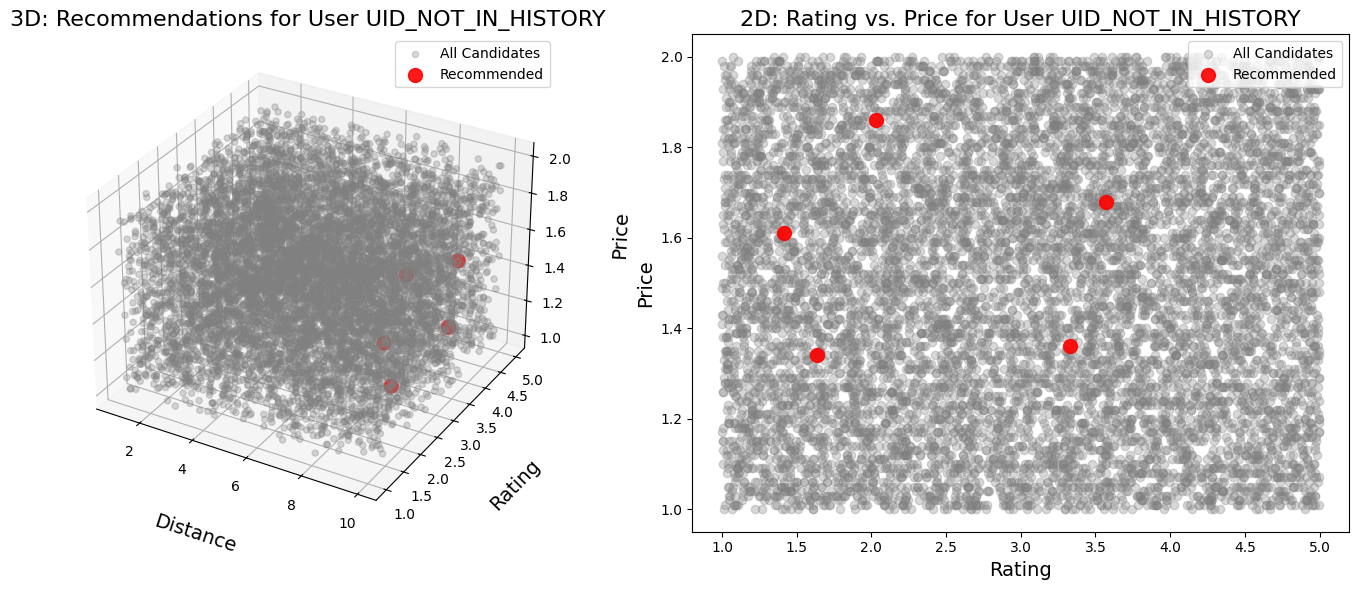


Processing visualizations for user: UID42085
User UID42085 (vector=[1.0, 1.56, 127.72]) belongs to cluster: 2
Number of candidate parking spots in the same cluster: 0
No candidates found in the same cluster. Falling back to global nearest candidates.


C:\Users\vae.tiolamon\AppData\Local\Temp\ipykernel_12140\3078382967.py:65: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  user_history['rating'].fillna(global_avg_rating, inplace=True)
C:\Users\vae.tiolamon\AppData\Local\Temp\ipykernel_12140\3078382967.py:66: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values alwa

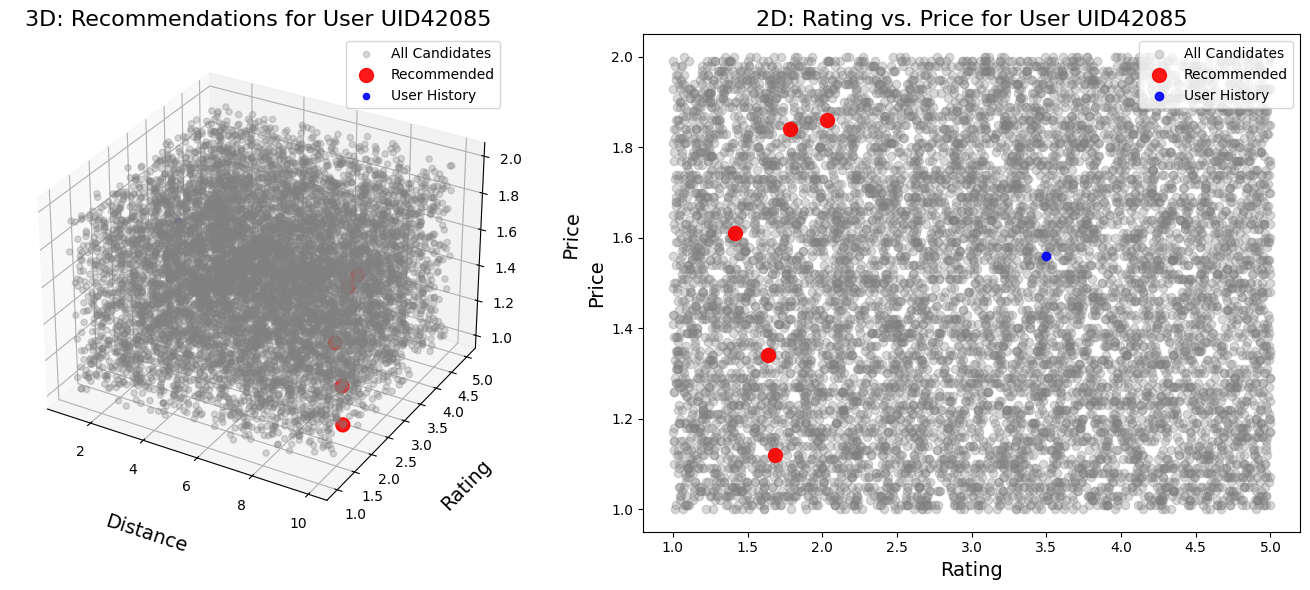


Processing visualizations for user: UID18737
No history available for user UID18737. Generating fake history data.
User UID18737 (vector=[4.910381410306483, 1.7524425287197978, 44.602953397271506]) belongs to cluster: 0
Number of candidate parking spots in the same cluster: 10000


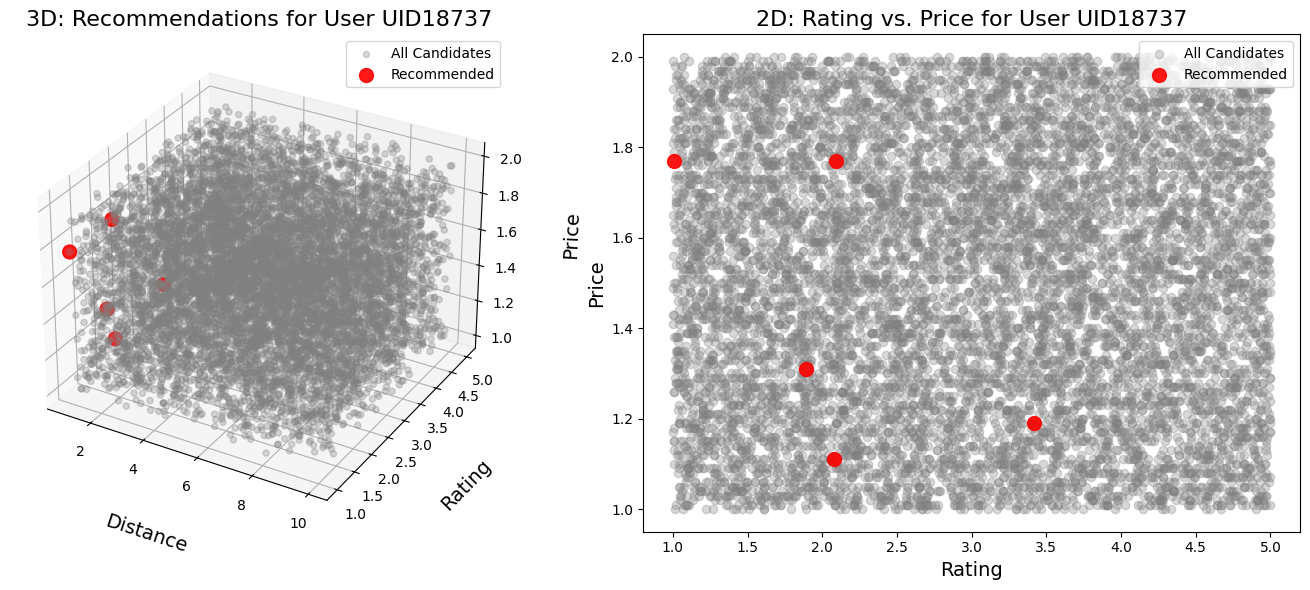


Processing visualizations for user: UID97023
User UID97023 (vector=[5.0, 1.653734406255683, 103.5675]) belongs to cluster: 2
Number of candidate parking spots in the same cluster: 0
No candidates found in the same cluster. Falling back to global nearest candidates.


C:\Users\vae.tiolamon\AppData\Local\Temp\ipykernel_12140\3078382967.py:65: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  user_history['rating'].fillna(global_avg_rating, inplace=True)
C:\Users\vae.tiolamon\AppData\Local\Temp\ipykernel_12140\3078382967.py:66: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values alwa

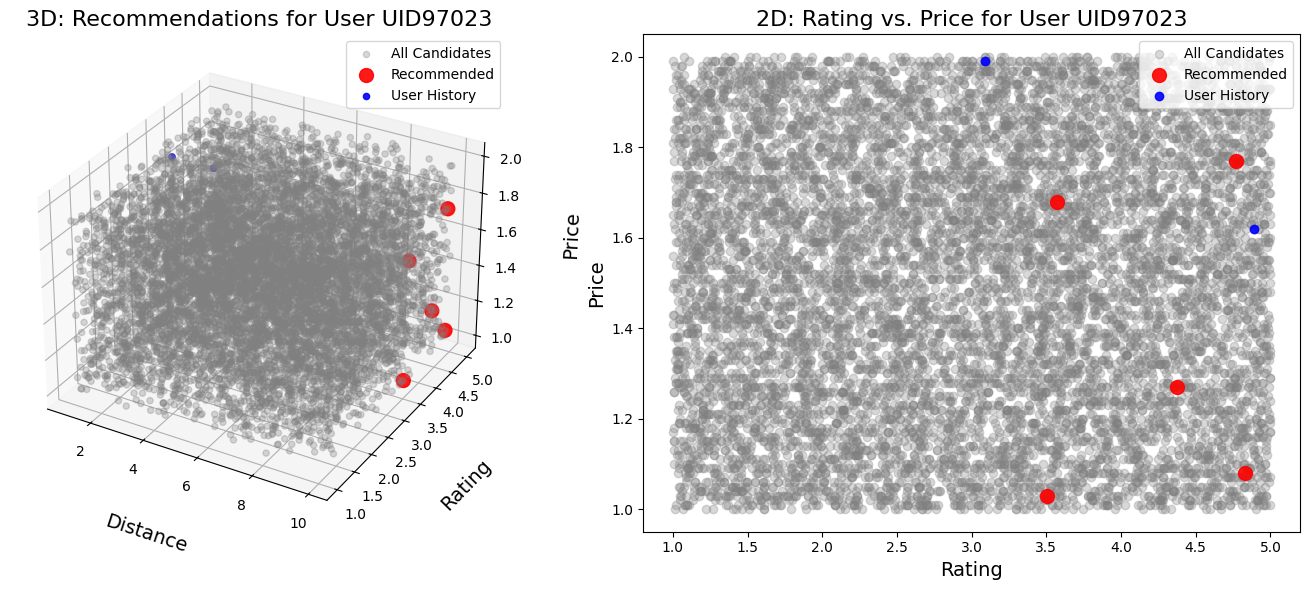

In [9]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from datetime import datetime
import json
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # For 3D plotting

# --- Load JSON Datasets ---
user_data = pd.read_json('database_generator/user_data.json')
landlord_data = pd.read_json('database_generator/landlord_data.json')
history_data = pd.read_json('database_generator/history_data.json')
private_parking_data = pd.read_json('database_generator/private_parking.json')
public_parking_data = pd.read_json('database_generator/public_parking.json')

# --- Process History Data ---
# Merge history_data with private_parking_data to obtain price information.
merged_history = pd.merge(
    history_data,
    private_parking_data[['private_id', 'price_per_hour']],
    left_on='parking_id',
    right_on='private_id',
    how='left'
)
merged_history['price'] = merged_history['price_per_hour']

# Convert "distance" from a string like "40.78 KM" to a numeric value.
merged_history['distance'] = merged_history['distance'].astype(str).str.extract(r'([\d\.]+)')[0].astype(float)

# --- JSON Template for a Single Temporary Candidate Record ---
temp_data_template = {
    "user_id": "UIDXXXXXX",
    "parking_id": "PRI80775",
    "rating": 4.2,        # Estimated satisfaction score
    "price": 1.45,        # Current price per hour from parking data
    "distance": 3.2,      # Real-time computed distance (in km)
    "datetime": "2023-08-01T10:00:00"  # Time of parking search/request
}
with open('temp_data_template.json', 'w') as f:
    json.dump(temp_data_template, f, indent=4)

# --- Create Temporary Candidate Data from Private Parking Data ---
temp_data = private_parking_data.copy()
temp_data = temp_data.rename(columns={"private_id": "parking_id", "price_per_hour": "price"})
# If candidate data doesn't include rating, generate a random rating between 1 and 5.
if "rating" not in temp_data.columns:
    temp_data["rating"] = np.random.uniform(1, 5, size=len(temp_data))
# Generate a random distance for demonstration (in practice, compute using real coordinates).
temp_data["distance"] = np.random.uniform(1, 10, size=len(temp_data))
# Set current datetime for candidate records.
temp_data["datetime"] = datetime.now().isoformat()

# --- Function: Get User Preference Vector with Fake Data Fallback ---
def get_user_vector(user_id, history_df):
    """
    Returns the user preference vector as [avg_rating, avg_price, avg_distance].
    If the user has no history, randomly generates fake data within given thresholds.
    """
    user_history = history_df[history_df['user_id'] == user_id].copy()
    if not user_history.empty:
        # Fill missing values with global averages.
        global_avg_rating = history_df['rating'].mean()
        global_avg_price = history_df['price'].mean()
        global_avg_distance = history_df['distance'].mean()
        user_history['rating'].fillna(global_avg_rating, inplace=True)
        user_history['price'].fillna(global_avg_price, inplace=True)
        user_history['distance'].fillna(global_avg_distance, inplace=True)
        avg_rating = user_history['rating'].mean()
        avg_price = user_history['price'].mean()
        avg_distance = user_history['distance'].mean()
    else:
        print(f"No history available for user {user_id}. Generating fake history data.")
        # Fake data thresholds based on sample history:
        avg_rating = np.random.uniform(1, 5)
        avg_price = np.random.uniform(1.09, 1.88)
        avg_distance = np.random.uniform(36.01, 114.93)
    return np.array([[avg_rating, avg_price, avg_distance]])

# --- Function: Train KMeans on Historical Data ---
def train_kmeans_on_history(history_df, num_clusters=5):
    """
    Trains a KMeans model using features from the history data.
    Expected features: 'rating', 'price', 'distance'
    """
    features = history_df[['rating', 'price', 'distance']].copy()
    features['rating'] = pd.to_numeric(features['rating'], errors='coerce')
    features['price'] = pd.to_numeric(features['price'], errors='coerce')
    features['distance'] = pd.to_numeric(features['distance'], errors='coerce')
    features.fillna(features.mean(), inplace=True)
    
    kmeans = KMeans(n_clusters=num_clusters, random_state=42, n_init=10)
    kmeans.fit(features.to_numpy())
    history_df['cluster'] = kmeans.labels_
    return kmeans

# --- Function: Recommend Parking Using Temporary Data ---
def recommend_parking_with_kmeans(user_id, history_df, temp_data_df, kmeans_model):
    """
    For a given user_id, uses their preference vector (or fake data if none exists)
    to determine a target cluster. Recommends candidate parking spots from temp_data_df
    that belong to that cluster. If none are found, falls back to the top 5 nearest candidates
    based on Euclidean distance.
    """
    user_vector = get_user_vector(user_id, history_df)
    user_cluster = kmeans_model.predict(user_vector)[0]
    print(f"User {user_id} (vector={user_vector.tolist()[0]}) belongs to cluster: {user_cluster}")
    
    # Assign clusters to candidate data.
    temp_features = temp_data_df[['rating', 'price', 'distance']].copy()
    predicted_clusters = kmeans_model.predict(temp_features.to_numpy())
    temp_data_df = temp_data_df.copy()  # Avoid SettingWithCopyWarning.
    temp_data_df['cluster'] = predicted_clusters
    
    # Select candidates in the same cluster.
    recommended = temp_data_df[temp_data_df['cluster'] == user_cluster].copy()
    print(f"Number of candidate parking spots in the same cluster: {len(recommended)}")
    
    # Fallback: If no candidates in that cluster, rank all candidates by Euclidean distance.
    if recommended.empty:
        print("No candidates found in the same cluster. Falling back to global nearest candidates.")
        diffs = temp_data_df[['rating', 'price', 'distance']] - user_vector
        dists = np.linalg.norm(diffs.to_numpy(), axis=1)
        temp_data_df['euclidean_distance'] = dists
        recommended = temp_data_df.sort_values('euclidean_distance').head(5)
    else:
        recommended = recommended.sort_values('distance').head(5)
    
    return recommended

# --- Visualization Function (3D and 2D) ---
def visualize_kmeans_recommendations(user_ids, history_df, candidate_df, kmeans_model):
    """
    For each user in user_ids, computes recommendations and visualizes:
      - A 3D scatter plot: Distance (x), Rating (y), Price (z)
      - A 2D scatter plot: Rating (x), Price (y)
    Recommended spots are highlighted in red, and user history (if available) in blue.
    """
    for user_id in user_ids:
        print(f"\nProcessing visualizations for user: {user_id}")
        recommendations = recommend_parking_with_kmeans(user_id, history_df, candidate_df, kmeans_model)
        if recommendations.empty:
            print(f"No recommendations available for user {user_id}")
            continue

        user_history = history_df[history_df["user_id"] == user_id]
        if not user_history.empty:
            # Match historical parking IDs with candidate data.
            history_candidates = candidate_df[candidate_df["parking_id"].isin(user_history["parking_id"])]
        else:
            history_candidates = pd.DataFrame()
        
        # --- 3D Plot ---
        fig = plt.figure(figsize=(14, 6))
        ax = fig.add_subplot(121, projection='3d')
        
        # Plot all candidates.
        ax.scatter(candidate_df["distance"], candidate_df["rating"], candidate_df["price"],
                   color="gray", label="All Candidates", alpha=0.3)
        # Plot recommended candidates.
        ax.scatter(recommendations["distance"], recommendations["rating"], recommendations["price"],
                   color="red", s=100, label="Recommended", alpha=0.9)
        # Plot user history (if available).
        if not history_candidates.empty:
            ax.scatter(history_candidates["distance"], history_candidates["rating"], history_candidates["price"],
                       color="blue", label="User History", alpha=0.9)
        
        ax.set_title(f"3D: Recommendations for User {user_id}", fontsize=16)
        ax.set_xlabel("Distance", labelpad=20, fontsize=14)
        ax.set_ylabel("Rating", labelpad=20, fontsize=14)
        ax.set_zlabel("Price", labelpad=20, fontsize=14)
        ax.legend()
        
        # --- 2D Plot (Rating vs. Price) ---
        ax2 = fig.add_subplot(122)
        ax2.scatter(candidate_df["rating"], candidate_df["price"], color="gray", label="All Candidates", alpha=0.3)
        ax2.scatter(recommendations["rating"], recommendations["price"], color="red", s=100, label="Recommended", alpha=0.9)
        if not history_candidates.empty:
            ax2.scatter(history_candidates["rating"], history_candidates["price"], color="blue", label="User History", alpha=0.9)
        
        ax2.set_title(f"2D: Rating vs. Price for User {user_id}", fontsize=16)
        ax2.set_xlabel("Rating", fontsize=14)
        ax2.set_ylabel("Price", fontsize=14)
        ax2.legend()
        
        plt.tight_layout()
        plt.show()

# --- Train the KMeans Model Using Processed Historical Data ---
kmeans_model = train_kmeans_on_history(merged_history, num_clusters=3)

# --- Specify a List of User IDs for Visualization (including one with no history) ---
user_ids_to_test = ["UID_NOT_IN_HISTORY", "UID42085","UID18737", "UID97023"]

# Ensure candidate_df has cluster labels.
candidate_df = temp_data.copy()
candidate_df['cluster'] = kmeans_model.predict(candidate_df[['rating', 'price', 'distance']].to_numpy())

# Visualize recommendations for these users.
visualize_kmeans_recommendations(user_ids_to_test, merged_history, candidate_df, kmeans_model)


In [12]:
!pip install flask pandas numpy geopy scikit-learn


                                              0.0/103.0 kB ? eta -:--:--
     -------------------------------------- 103.0/103.0 kB 3.0 MB/s eta 0:00:00
  Using cached geopy-2.4.1-py3-none-any.whl (125 kB)
                                              0.0/11.1 MB ? eta -:--:--
     -                                        0.3/11.1 MB 7.0 MB/s eta 0:00:02
     --                                       0.7/11.1 MB 7.5 MB/s eta 0:00:02
     ---                                      1.1/11.1 MB 7.7 MB/s eta 0:00:02
     -----                                    1.5/11.1 MB 7.8 MB/s eta 0:00:02
     ------                                   1.8/11.1 MB 7.7 MB/s eta 0:00:02
     -------                                  2.2/11.1 MB 7.8 MB/s eta 0:00:02
     ---------                                2.6/11.1 MB 7.8 MB/s eta 0:00:02
     ----------                               3.0/11.1 MB 7.9 MB/s eta 0:00:02
     ------------                             3.3/11.1 MB 7.9 MB/s eta 0:00:01
     ------


[notice] A new release of pip is available: 23.1.2 -> 25.0.1
[notice] To update, run: C:\Users\Tristan\miniconda3\python.exe -m pip install --upgrade pip


In [11]:
import os
import pandas as pd
import numpy as np
from geopy.geocoders import Nominatim
from geopy.distance import geodesic
from datetime import datetime
from sklearn.cluster import KMeans

# -------------------------------
# Configuration
# -------------------------------
user_id = "UID25840"  # Change this to your desired user ID

# -------------------------------
# Helper Functions
# -------------------------------
def extract_city(address):
    """Extract the city (assumed to be the part after the comma)."""
    parts = address.split(',')
    return parts[-1].strip() if len(parts) > 1 else address.strip()

def get_coordinates(address):
    """Geocode an address using Nominatim with fallback to just the city."""
    geolocator = Nominatim(user_agent="parking_app_ml")
    test_address = address if "Germany" in address else address + ", Germany"
    location = geolocator.geocode(test_address)
    if location:
        return (location.latitude, location.longitude)
    # Fallback: try just the city.
    city = extract_city(address)
    test_city = city if "Germany" in city else city + ", Germany"
    location = geolocator.geocode(test_city)
    if location:
        return (location.latitude, location.longitude)
    return (None, None)

def compute_distance(row, user_coords):
    """Compute the geodesic distance (in km) between the user's coordinates and candidate's coordinates, rounded to 2 decimals."""
    try:
        candidate_lat = float(row['latitude'])
        candidate_lon = float(row['longitude'])
    except Exception as e:
        print("Error converting candidate coordinates to float:", e)
        return np.nan
    candidate_coords = (candidate_lat, candidate_lon)
    d = geodesic(user_coords, candidate_coords).kilometers
    return round(d, 2)

def get_user_vector_for_type(user_id, history_df, prefix):
    """
    Computes the user preference vector [avg_rating, avg_price, avg_distance] for a given type,
    where 'prefix' is "PRI" for private or "PUB" for public.
    If no history exists for that type, generates fake values.
    """
    sub = history_df[history_df['parking_id'].str.startswith(prefix)]
    if not sub.empty and 'price' in sub.columns and sub['price'].notna().sum() > 0:
        # Use the available history.
        avg_rating = sub['rating'].mean()
        avg_price = sub['price'].mean()  # Note: history should have been merged to include price.
        # Convert the "distance" string to float.
        sub['dist_num'] = sub['distance'].astype(str).str.extract(r'([\d\.]+)')[0].astype(float)
        avg_distance = sub['dist_num'].mean()
    else:
        # Generate fake values.
        avg_rating = np.random.uniform(1, 5)
        avg_price = np.random.uniform(1.09, 1.88)
        avg_distance = np.random.uniform(36.01, 114.93)
    return np.array([[avg_rating, avg_price, avg_distance]])

# -------------------------------
# Data Loading
# -------------------------------
# Load JSON files from the "database_generator" folder.
user_data = pd.read_json(os.path.join('database_generator', 'user_data.json'))
history_data = pd.read_json(os.path.join('database_generator', 'history_data.json'))
private_parking_data = pd.read_json(os.path.join('database_generator', 'private_parking.json'))
public_parking_data = pd.read_json(os.path.join('database_generator', 'public_parking.json'))

# For history_data, merge with private_parking_data (for private records) to get price info.
# We'll merge only the records that refer to private parking.
private_history = history_data[history_data['parking_id'].str.startswith("PRI")].copy()
if not private_history.empty:
    private_history = pd.merge(
        private_history,
        private_parking_data[['private_id', 'price_per_hour']],
        left_on='parking_id',
        right_on='private_id',
        how='left'
    )
    private_history['price'] = private_history['price_per_hour']
    private_history['distance'] = private_history['distance'].astype(str).str.extract(r'([\d\.]+)')[0].astype(float)

# Similarly, for public history:
public_history = history_data[history_data['parking_id'].str.startswith("PUB")].copy()
if not public_history.empty:
    # For public, assume merging with public_parking_data using "public_id"
    public_history = pd.merge(
        public_history,
        public_parking_data[['public_id', 'price_per_hour']],
        left_on='parking_id',
        right_on='public_id',
        how='left'
    )
    public_history['price'] = public_history['price_per_hour']
    public_history['distance'] = public_history['distance'].astype(str).str.extract(r'([\d\.]+)')[0].astype(float)

# -------------------------------
# Get User Info
# -------------------------------
user_row = user_data[user_data['user_id'] == user_id]
if user_row.empty:
    raise ValueError(f"User {user_id} not found in user_data.json")
user_address = user_row.iloc[0]['address']
print("User address:", user_address)
user_city = extract_city(user_address)
print("Extracted city:", user_city)
if 'latitude' in user_row and 'longitude' in user_row:
    user_lat = user_row.iloc[0].get('latitude', None)
    user_lon = user_row.iloc[0].get('longitude', None)
    if pd.notna(user_lat) and pd.notna(user_lon):
        user_coords = (float(user_lat), float(user_lon))
    else:
        user_coords = get_coordinates(user_address)
else:
    user_coords = get_coordinates(user_address)
if None in user_coords:
    raise ValueError(f"Could not geocode user's address: {user_address}")
print("User coordinates:", user_coords)

# -------------------------------
# Filter Candidate Parking by City
# -------------------------------
# For private parking:
private_candidates = private_parking_data[private_parking_data['city'] == user_city].copy()
# Ensure a rating exists; if not, generate one.
if "rating" not in private_candidates.columns:
    private_candidates["rating"] = np.random.uniform(1, 5, size=len(private_candidates))
# Create a column 'price' from 'price_per_hour'
private_candidates["price"] = private_candidates["price_per_hour"]
# Compute calc_distance using geodesic (rounded to 2 decimals)
private_candidates['calc_distance'] = private_candidates.apply(lambda row: compute_distance(row, user_coords), axis=1)
print(f"Private parking candidates in {user_city}: {len(private_candidates)}")

# For public parking:
if 'city' not in public_parking_data.columns:
    public_parking_data['city'] = public_parking_data['address'].apply(extract_city)
public_candidates = public_parking_data[public_parking_data['city'] == user_city].copy()
if "rating" not in public_candidates.columns:
    public_candidates["rating"] = np.random.uniform(1, 5, size=len(public_candidates))
public_candidates["price"] = public_candidates["price_per_hour"]
public_candidates['calc_distance'] = public_candidates.apply(lambda row: compute_distance(row, user_coords), axis=1)
print(f"Public parking candidates in {user_city}: {len(public_candidates)}")

# -------------------------------
# KMeans-based Ranking for Private Parking
# -------------------------------
# Build feature array for private candidates: [rating, price, calc_distance]
X_private = private_candidates[['rating', 'price', 'calc_distance']].to_numpy()
if len(X_private) == 0:
    raise ValueError("No private candidates available for this city.")
kmeans_private = KMeans(n_clusters=3, random_state=42, n_init=10)
kmeans_private.fit(X_private)
private_candidates['cluster'] = kmeans_private.predict(X_private)
# Compute user vector for private: using history if available; else fake.
user_vector_private = get_user_vector_for_type(user_id, private_history, "PRI")
user_cluster_private = kmeans_private.predict(user_vector_private)[0]
print(f"User private vector: {user_vector_private.tolist()[0]}, predicted cluster: {user_cluster_private}")
private_candidates_in_cluster = private_candidates[private_candidates['cluster'] == user_cluster_private].copy()
# Compute Euclidean difference in feature space.
private_candidates_in_cluster['euclidean_diff'] = private_candidates_in_cluster[['rating', 'price', 'calc_distance']].apply(
    lambda row: np.linalg.norm(row.to_numpy() - user_vector_private[0]), axis=1)
private_sorted = private_candidates_in_cluster.sort_values('euclidean_diff').reset_index(drop=True)
top15_private = private_sorted.head(15)

# -------------------------------
# KMeans-based Ranking for Public Parking
# -------------------------------
X_public = public_candidates[['rating', 'price', 'calc_distance']].to_numpy()
if len(X_public) == 0:
    raise ValueError("No public candidates available for this city.")
kmeans_public = KMeans(n_clusters=3, random_state=42, n_init=10)
kmeans_public.fit(X_public)
public_candidates['cluster'] = kmeans_public.predict(X_public)
user_vector_public = get_user_vector_for_type(user_id, public_history, "PUB")
user_cluster_public = kmeans_public.predict(user_vector_public)[0]
print(f"User public vector: {user_vector_public.tolist()[0]}, predicted cluster: {user_cluster_public}")
public_candidates_in_cluster = public_candidates[public_candidates['cluster'] == user_cluster_public].copy()
public_candidates_in_cluster['euclidean_diff'] = public_candidates_in_cluster[['rating', 'price', 'calc_distance']].apply(
    lambda row: np.linalg.norm(row.to_numpy() - user_vector_public[0]), axis=1)
public_sorted = public_candidates_in_cluster.sort_values('euclidean_diff').reset_index(drop=True)
top1_public = public_sorted.head(1)

# -------------------------------
# Save Results to CSV Files
# -------------------------------
top15_private.to_csv("top15_private_parking.csv", index=False)
top1_public.to_csv("top1_public_parking.csv", index=False)

print("\nCSV files saved: 'top15_private_parking.csv' and 'top1_public_parking.csv'")
print("\nTop 15 Private Parking Spaces:")
print(top15_private[['private_id', 'name', 'address', 'calc_distance', 'euclidean_diff']])
print("\nTop 1 Public Parking Space:")
public_id_field = "public_id" if "public_id" in public_candidates.columns else "private_id"
print(top1_public[[public_id_field, 'name', 'address', 'calc_distance', 'euclidean_diff']])



User address: 17 Technologiepark, Ulm
Extracted city: Ulm
User coordinates: (48.3984968, 9.9912458)
Private parking candidates in Ulm: 744
Public parking candidates in Ulm: 4


c:\Users\Tristan\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


User private vector: [3.3211828605914304, 1.494691007845504, 106.95614906457453], predicted cluster: 1


c:\Users\Tristan\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


User public vector: [3.3101971105386943, 2.841370814200919, 106.84463321760555], predicted cluster: 2

CSV files saved: 'top15_private_parking.csv' and 'top1_public_parking.csv'

Top 15 Private Parking Spaces:
   private_id          name                       address  calc_distance  \
0    PRI22586  Property 402         Handelsstraße 65, Ulm           8.17   
1    PRI31741    Property 7         Am Sportplatz 74, Ulm           7.95   
2    PRI25871  Property 246       Industriestraße 13, Ulm           7.93   
3    PRI57996  Property 995        Autobahnstraße 33, Ulm           7.69   
4    PRI66167  Property 993         Lessingstraße 27, Ulm           7.69   
5    PRI32604  Property 104      Hafenbahnstraße 141, Ulm           7.62   
6    PRI73549  Property 152  Ludwigsburger Straße 96, Ulm           7.55   
7    PRI69740  Property 113           Hegelstraße 67, Ulm           7.54   
8    PRI28326  Property 139       Autobahnstraße 120, Ulm           7.39   
9    PRI54135  Property 229   